# Faster R-CNN in Pytorch with Example

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CV

/content/drive/.shortcut-targets-by-id/1Z7Jw0F18-t6b1J_nNXzSsOUMRtwvcH17/CV


In [ ]:
%pwd

'/content/drive/.shortcut-targets-by-id/1Z7Jw0F18-t6b1J_nNXzSsOUMRtwvcH17/CV'

In [ ]:
!python model.py

In [ ]:
# # chay data
# %cd /content/drive/MyDrive/CV/lp_recognize/lp_manual_duyennguyen_384

In [ ]:
%cd /content/drive/MyDrive/CV/lp_recognize/lp_manual_dongtrinh_1655

/content/drive/.shortcut-targets-by-id/1Z7Jw0F18-t6b1J_nNXzSsOUMRtwvcH17/CV/lp_recognize/lp_manual_dongtrinh_1655


In [ ]:
import numpy as np
import numba.cuda
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
from random import randrange
import matplotlib.patches as patches
import os
import glob
import shutil
import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [ ]:
def parse_annotation(label_dir, image_dir, first, end):
    '''
    Traverse the xml tree, get the annotations, and resize them to the scaled image size
    '''
    # img_h, img_w = img_size

    imgs = list(sorted(glob.glob(image_dir+'/*.jpg')))[first:end]
    labels = list(sorted(glob.glob(label_dir+'/*.txt')))[first:end]

    img_paths = []
    gt_boxes_all = []
    gt_classes_all = []
    # get image paths
    for object_ in range(len(imgs)):
        img_paths.append(imgs[object_])

        # get bboxes and their labels
        groundtruth_boxes = []
        groundtruth_classes = []
        with open(labels[object_],'r') as f: #b[0] = labels[object_]
          lines = []
          for line in f:
            lines.append(line.rstrip())
          new_lines = [[el] for el in lines]
          for j in range(len(new_lines)):
            for i in new_lines[j]:
              # print(i.split(' '))
              a = i.split(' ')
              b = np.array(a, float)
              # print(label)
              x_min = (b[1]-b[3]/2)*800
              y_min = (b[2]-b[4]/2)*800
              x_max = (b[1]+b[3]/2)*800
              y_max = (b[2]+b[4]/2)*800
              box = torch.Tensor([x_min,y_min,x_max,y_max])
              # box = box.cuda()
              groundtruth_boxes.append(box.tolist())
              # print(groundtruth_boxes)
              label= int(b[0])
              groundtruth_classes.append(label)
              # print(groundtruth_classes)
        # print('Image thu ',object_)
        # img_paths = list_to_np(img_paths)
        # img_paths = totensor(img_paths)
        gt_boxes_all.append(torch.Tensor(groundtruth_boxes).cuda())
        # print(gt_boxes_all)
        # print(type(gt_classes_all))
        gt_classes_all.append(groundtruth_classes)
        # gt_classes_all = list_to_np(gt_classes_all)
        # gt_classes_all = totensor(gt_classes_all)
        # print(gt_classes_all)

    return gt_boxes_all, gt_classes_all, img_paths

In [ ]:
"""
tools to convert specified type
"""
import torch as t
import numpy as np

def list_to_np(data):
  if isinstance(data, list):
    return np.array(data)


def tonumpy(data):
    if isinstance(data, np.ndarray):
        return data
    if isinstance(data, t.Tensor):
        return data.detach().cpu().numpy()


def totensor(data, cuda=True):
    # if isinstance(data, list):
    #   tensor =
    if isinstance(data, np.ndarray):
        tensor = t.from_numpy(data)
        print('tensor_1',tensor)
    if isinstance(data, t.Tensor):
        tensor = data.detach()
        print('tensor_2',torch.tensor_splitor)
    if cuda:
        tensor = tensor.cuda()
        print('tensor_3', tensor)
    return tensor


def scalar(data):
    if isinstance(data, np.ndarray):
        return data.reshape(1)[0]
    if isinstance(data, t.Tensor):
        return data.item()

In [ ]:
# a = [[1,2],[3,4]]
# a = list_to_np(a)
# totensor(a)

### Load Images

**Note:** The annotations should also contain the corresponding image path

In [ ]:
import cv2
class ObjectDetectionDataset(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.

    Returns
    ------------
    images: torch.Tensor of size (B, C, H, W)
    gt bboxes: torch.Tensor of size (B, max_objects, 4)
    gt classes: torch.Tensor of size (B, max_objects)
    '''
    def __init__(self, label_dir, img_dir, img_size, name2idx, first, end):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = name2idx

        #get a particular list
        self.first = first
        self.end = end

        self.img_data_all, self.gt_bboxes_all, self.gt_classes_all = self.get_data()

    def __len__(self):
        return self.img_data_all.size(dim=0)

    def __getitem__(self, idx):
        return self.img_data_all[idx], self.gt_bboxes_all[idx], self.gt_classes_all[idx]

    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        # device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

        gt_boxes_all, gt_classes_all, img_paths = parse_annotation(self.label_dir, self.img_dir, self.first, self.end)
        # gt_boxes_all = list_to_np(gt_boxes_all)
        # print(type(gt_boxes_all))
        # gt_boxes_all = totensor(gt_boxes_all)

        # gt_classes_all = list_to_np(gt_classes_all)
        # gt_classes_all = totensor(gt_classes_all)

        # img_paths = list_to_np(img_paths)
        # img_paths = totensor(img_paths)
        #fix none tensor
        for i,empty in enumerate(gt_boxes_all):
          if len(empty)==0:

            non_empty = torch.cat((empty, torch.rand((1,4))))
            gt_boxes_all[i] = non_empty
        for i,empty in enumerate(gt_classes_all):
          if len(empty) == 0:
            gt_classes_all[i].append(randrange(36))


        for i, img_path in enumerate(img_paths):

            # skip if the image path is not valid
            if (not img_path) or (not os.path.exists(img_path)):
                continue
            # read and resize image
            img = io.imread(img_path)
            img = cv2.resize(img, self.img_size)
            # img = resize(img, self.img_size)

            # convert image to torch tensor and reshape it so channels come first
            img_tensor = torch.from_numpy(img).permute(2, 0, 1)

            # encode class names as integers
            gt_classes = gt_classes_all[i]
            gt_idx = torch.Tensor([self.name2idx[name] for name in gt_classes])
            # print(gt_idx)
            img_data_all.append(img_tensor)
            gt_idxs_all.append(gt_idx)
            # print(gt_idxs_all)


        # pad bounding boxes and classes so they are of the same size
        gt_bboxes_pad = pad_sequence(gt_boxes_all, batch_first=True, padding_value=-1)
        # print(gt_bboxes_pad)
        # print(gt_idxs_all)
        gt_classes_pad = pad_sequence(gt_idxs_all, batch_first=True, padding_value=-1)
        # print(gt_classes_pad)
        # stack all images
        img_data_stacked = torch.stack(img_data_all, dim=0)

        return img_data_stacked.to(dtype=torch.float32), gt_bboxes_pad, gt_classes_pad

In [ ]:
img_width = 800
img_height = 800
label_dir = 'labels'
image_dir = 'images'
name2idx = {i:i for i in range(0,37)}
name2idx["pad"] = -1
idx2name = {v:k for k, v in name2idx.items()}

In [ ]:
# name2idx

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops.boxes import torchvision
from tqdm import tqdm
import glob
import torch
from torchvision import ops
import torch.nn.functional as F
import torch.optim as optim
import numba.cuda

# -------------- Data Untils -------------------
# @numba.jit
def parse_annotation(label_dir, image_dir, first, end):
    '''
    Traverse the xml tree, get the annotations, and resize them to the scaled image size
    '''
    # img_h, img_w = img_size

    imgs = list(sorted(glob.glob(image_dir+'/*.jpg')))[first:end]
    labels = list(sorted(glob.glob(label_dir+'/*.txt')))[first:end]

    img_paths = []
    gt_boxes_all = []
    gt_classes_all = []
    # get image paths
    for object_ in range(len(imgs)):
        img_paths.append(imgs[object_])

        # get bboxes and their labels
        groundtruth_boxes = []
        groundtruth_classes = []
        with open(labels[object_],'r') as f: #b[0] = labels[object_]
          lines = []
          for line in f:
            lines.append(line.rstrip())
          new_lines = [[el] for el in lines]
          for j in range(len(new_lines)):
            for i in new_lines[j]:
              # print(i.split(' '))
              a = i.split(' ')
              b = np.array(a, float)
              # print(label)
              x_min = (b[1]-b[3]/2)*800
              y_min = (b[2]-b[4]/2)*800
              x_max = (b[1]+b[3]/2)*800
              y_max = (b[2]+b[4]/2)*800
              box = torch.Tensor([x_min,y_min,x_max,y_max])
              groundtruth_boxes.append(box.tolist())
              # print(groundtruth_boxes)
              label= int(b[0])
              groundtruth_classes.append(label)
              # print(groundtruth_classes)
        # print('Image thu ',object_)
        gt_boxes_all.append(torch.Tensor(groundtruth_boxes))
        # print(gt_boxes_all)
        gt_classes_all.append(groundtruth_classes)
        # print(gt_classes_all)

    return gt_boxes_all, gt_classes_all, img_paths

# -------------- Prepocessing utils ----------------

def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)

def gen_anc_centers(out_size):
    out_h, out_w = out_size
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    out_size = torch.as_tensor(out_size, device = device)
    device = out_size.device
    anc_pts_x = torch.arange(0, out_w, device = device) + 0.5
    anc_pts_y = torch.arange(0, out_h, device = device) + 0.5

    return anc_pts_x, anc_pts_y

def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']

    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes

    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor

    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)

    return proj_bboxes

def generate_proposals(anchors, offsets):

    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')
    # print('off_device',offsets.device)
    device = offsets.device
    # print(device)
    anchors = anchors.to(device)
    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors, device=device)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    device = anc_pts_x.device
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) \
                              , anc_pts_y.size(dim=0), n_anc_boxes, 4, device=device) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]

    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale

                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)

    return anc_base

def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):

    # flatten anchor boxes
    # print('anc_boxes', anc_boxes_all.device)
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)
    # print('anc_boxes',anc_boxes_flat.device)
    # get total anchor boxes for a single image
    tot_anc_boxes = anc_boxes_flat.size(dim=1)
    device = anc_boxes_flat.device
    # print(device)
    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.size(dim=1)), device = device)
    # ious_mat = ious_mat.to('cpu')
    print('anc_flat', anc_boxes_flat.device)
    print('gt_all',gt_bboxes_all.device)
    print('ious_mat',ious_mat.device)
    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = gt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)
        # ious_mat = ious_mat.to('cpu')
    return ious_mat

def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.8, neg_thresh=0.2): #pos: 0.7
    '''
    Prepare necessary data required for training

    Input
    ------
    anc_boxes_all - torch.Tensor of shape (B, w_amap, h_amap, n_anchor_boxes, 4)
        all anchor boxes for a batch of images
    gt_bboxes_all - torch.Tensor of shape (B, max_objects, 4)
        padded ground truth boxes for a batch of images
    gt_classes_all - torch.Tensor of shape (B, max_objects)
        padded ground truth classes for a batch of images

    Returns
    ---------
    positive_anc_ind -  torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    negative_anc_ind - torch.Tensor of shape (n_pos,)
        flattened positive indices for all the images in the batch
    GT_conf_scores - torch.Tensor of shape (n_pos,), IoU scores of +ve anchors
    GT_offsets -  torch.Tensor of shape (n_pos, 4),
        offsets between +ve anchors and their corresponding ground truth boxes
    GT_class_pos - torch.Tensor of shape (n_pos,)
        mapped classes of +ve anchors
    positive_anc_coords - (n_pos, 4) coords of +ve anchors (for visualization)
    negative_anc_coords - (n_pos, 4) coords of -ve anchors (for visualization)
    positive_anc_ind_sep - list of indices to keep track of +ve anchors
    '''
    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1] # max number of groundtruth bboxes in a batch

    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap

    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    # print('anc_all',anc_boxes_all.device)
    # print('gt_bboxes_all', gt_bboxes_all.device)
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)
    # print('anc_boxes_all',anc_boxes_all.device)

    # for every groundtruth bbox in an image, find the iou
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)

    # get positive anchor boxes

    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0)
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)

    positive_anc_ind_sep = torch.where(positive_anc_mask)[0] # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]

    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)

    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]

    # get gt classes of the +ve anchor boxes

    # expand gt classes to map against every anchor box
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N).to('cuda')
    print(gt_classes_expand.device)
    # print(max_iou_per_anc_ind.device)
    max_iou_per_anc_ind = max_iou_per_anc_ind.to("cuda")
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1).cuda()
    print('GT_class',GT_class.type())
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]

    # get gt bbox coordinates of the +ve anchor boxes

    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]

    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2) # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]

    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)

    # get -ve anchors

    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]

    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep

# # -------------- Visualization utils ----------------

def display_img(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img.astype(np.uint8))

    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)
    if classes:
        assert len(bboxes) == len(classes)
    # convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.numpy()
        # display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category
        if classes:
            if classes[c] == 'pad':
                continue
            ax.text(x + 5, y + 20, classes[c], bbox=dict(facecolor='yellow', alpha=0.5))
        c += 1

    return fig, ax

def display_grid(x_points, y_points, fig, ax, special_point=None):
    # plot grid
    for x in x_points:
        for y in y_points:
            ax.scatter(x, y, color="w", marker='+')

    # plot a special point we want to emphasize on the grid
    if special_point:
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')

    return fig, ax

#### Create Dataset and Dataloaders

In [ ]:
%cd /content/drive/MyDrive/CV/lp_recognize/lp_manual_dongtrinh_1655

/content/drive/.shortcut-targets-by-id/1Z7Jw0F18-t6b1J_nNXzSsOUMRtwvcH17/CV/lp_recognize/lp_manual_dongtrinh_1655


In [ ]:
od_dataset = ObjectDetectionDataset(label_dir,image_dir, (img_height, img_width),name2idx,0,300)

In [ ]:
od_dataloader = DataLoader(od_dataset, batch_size=2)
# next(iter(od_dataloader))

In [ ]:
# for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
#     print(gt_classes_batch)

#### Grab a batch for demonstration

In [ ]:
for img_batch, gt_bboxes_batch, gt_classes_batch in od_dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    # break
#dang mac dinh so batch_size la 2 => can sua
# img_data_all = img_data_all[:2]
# gt_bboxes_all = gt_bboxes_all[:2]
# gt_classes_all = gt_classes_all[:2]

### Display Images and Bounding Boxes

In [ ]:
# gt_classes_all

In [ ]:
# get class names
# can tao vong for cho so batch_size co dinh
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

# gt_class_3 = gt_classes_all[2].long()
# gt_class_3 = [idx2name[idx.item()] for idx in gt_class_3]

# gt_class_4 = gt_classes_all[3].long()
# gt_class_4 = [idx2name[idx.item()] for idx in gt_class_4]

# gt_class_5 = gt_classes_all[4].long()
# gt_class_5 = [idx2name[idx.item()] for idx in gt_class_5]

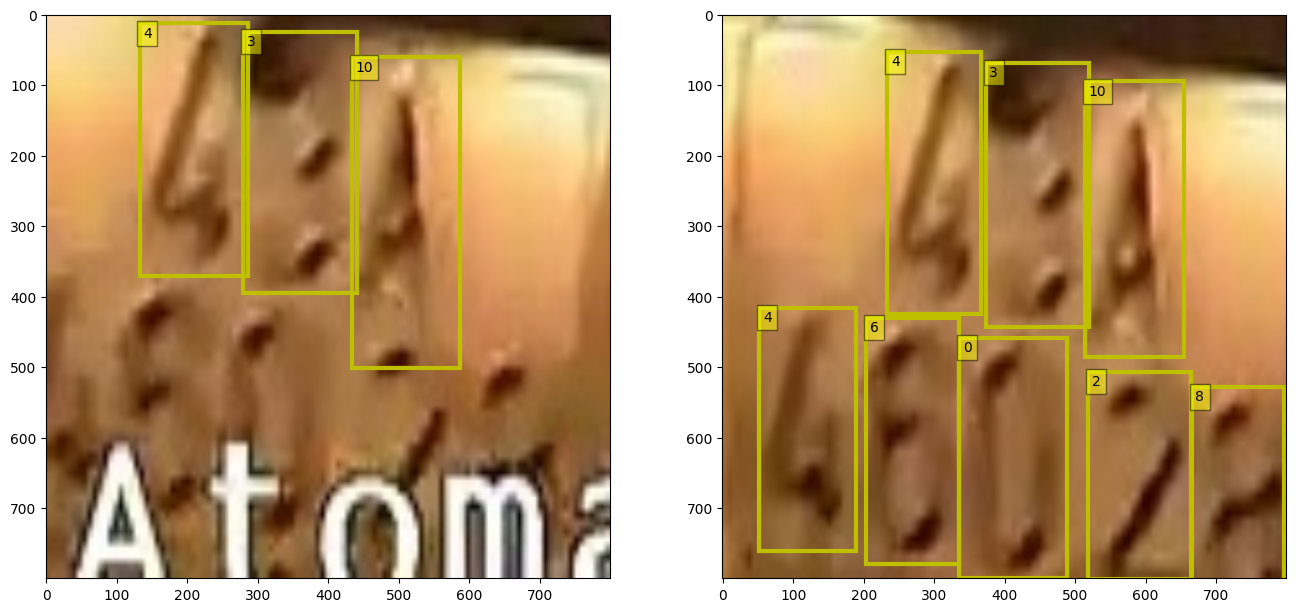

In [ ]:
# # 5 is batch_size
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)
# # fig, _ = display_bbox(gt_bboxes_all[2], fig, axes[2], classes=gt_class_3)
# # fig, _ = display_bbox(gt_bboxes_all[3], fig, axes[3], classes=gt_class_4)
# # fig, _ = display_bbox(gt_bboxes_all[4], fig, axes[4], classes=gt_class_5)


## Convolutional Backbone Network

We will use the first 4 layers of resnet50 as our convolutional backbone

In [ ]:
model = torchvision.models.resnet50(pretrained=True)
# model_new = model.resnet50(weights=models.ResNet50_Weights.DEFAULT)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#bo di lop pooling va lop Linear cuoi
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [ ]:
list(model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [ ]:
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [ ]:
img_data_all.size()

torch.Size([2, 3, 800, 800])

In [ ]:
# run the image through the backbone
out = backbone(img_data_all)

In [ ]:
out.size()

torch.Size([2, 2048, 25, 25])

In [ ]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [ ]:
out_c, out_h, out_w

(2048, 25, 25)

#### Check how much the image has been down-scaled

In [ ]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

### Visualize feature maps

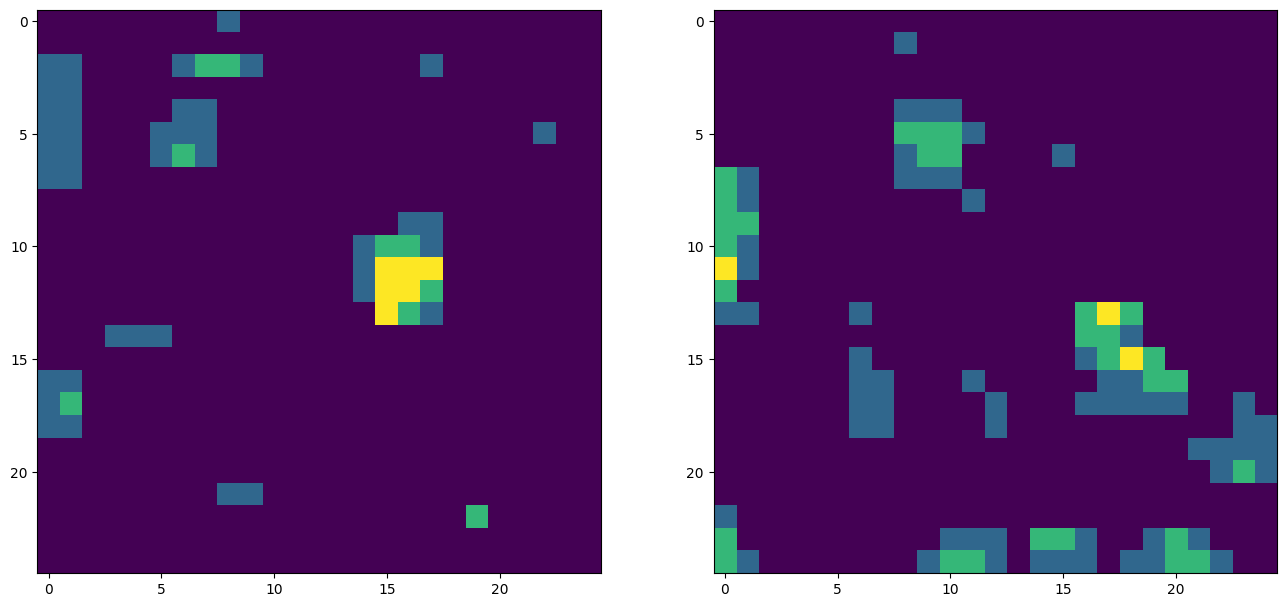

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:5]]

fig, axes = display_img(filters_data, fig, axes)

### Generate and Plot Anchor Points

In [ ]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

### Display Grid Mapping

In [ ]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

In [ ]:
anc_pts_x_proj

tensor([ 16.,  48.,  80., 112., 144., 176., 208., 240., 272., 304., 336., 368.,
        400., 432., 464., 496., 528., 560., 592., 624., 656., 688., 720., 752.,
        784.], device='cuda:0')

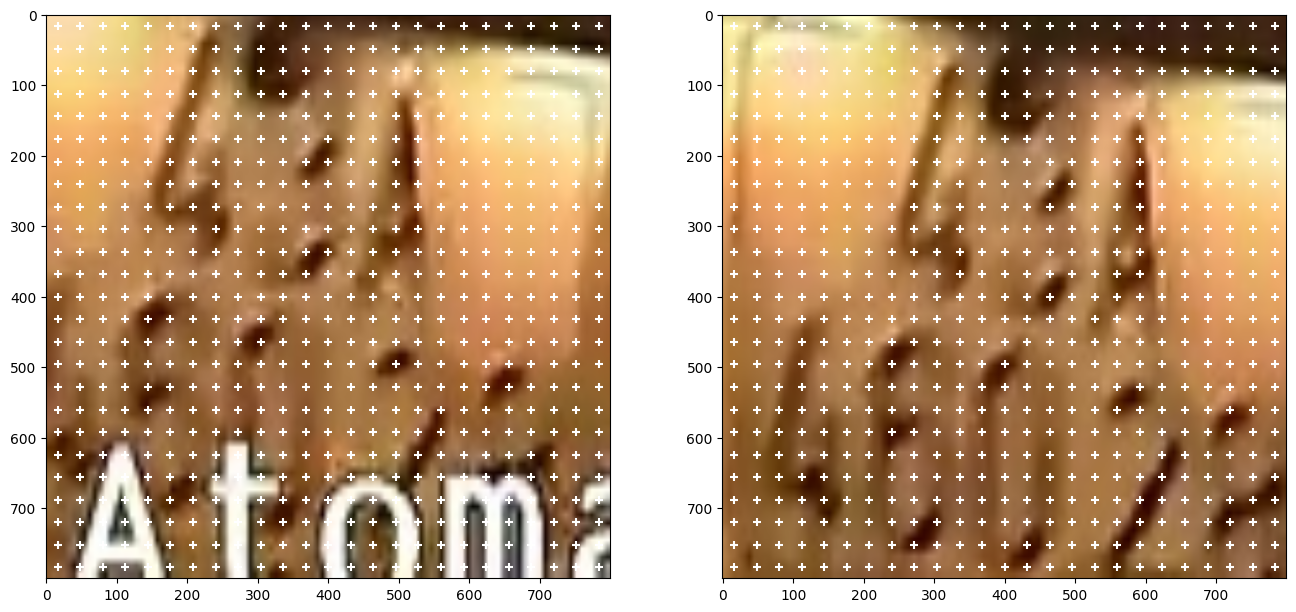

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj.cpu(), anc_pts_y_proj.cpu(), fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj.cpu(), anc_pts_y_proj.cpu(), fig, axes[1])
# # fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[2])
# # fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[3])
# # fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[4])

### Create Anchor Boxes around Anchor points

In [ ]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [ ]:
anc_base.device

device(type='cuda', index=0)

In [ ]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

In [ ]:
# (anc_boxes_all)

In [ ]:
img_data_all.size(dim=0) #tra ra so anh

2

In [ ]:
anc_boxes_all.shape

torch.Size([2, 25, 25, 9, 4])

In [ ]:
# anc_boxes_all.clone()

In [ ]:
# anc_boxes_all.clone().reshape(2,-1,4) == -1

In [ ]:
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')


In [ ]:
anc_boxes_proj[0].size()

torch.Size([25, 25, 9, 4])

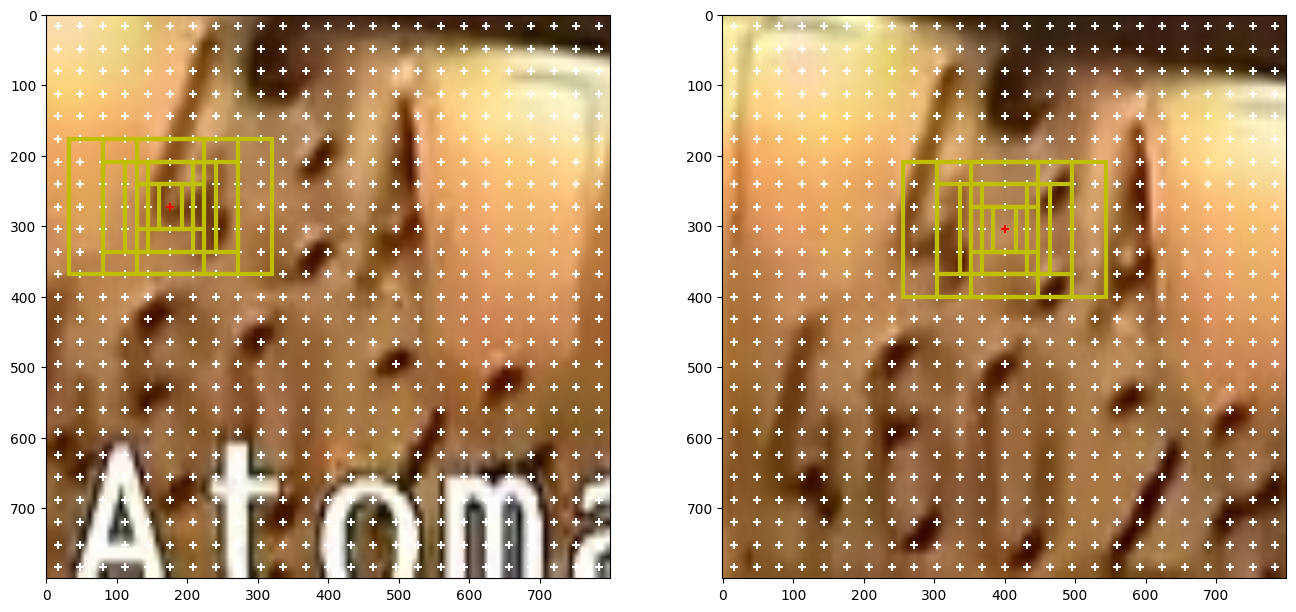

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 8]
sp_2 = [12, 9]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]
# # bboxes_3 = anc_boxes_proj[2][sp_2[0], sp_2[1]]
# # bboxes_4 = anc_boxes_proj[3][sp_2[0], sp_2[1]]
# # bboxes_5 = anc_boxes_proj[4][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj.cpu(), anc_pts_y_proj.cpu(), fig, axes[0], (anc_pts_x_proj.cpu()[sp_1[0]], anc_pts_y_proj.cpu()[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj.cpu(), anc_pts_y_proj.cpu(), fig, axes[1], (anc_pts_x_proj.cpu()[sp_2[0]], anc_pts_y_proj.cpu()[sp_2[1]]))
# # fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[2], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
# # fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[3], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
# # fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[4], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))


fig, _ = display_bbox(bboxes_1.cpu(), fig, axes[0])
fig, _ = display_bbox(bboxes_2.cpu(), fig, axes[1])
# # fig, _ = display_bbox(bboxes_3, fig, axes[2])
# # fig, _ = display_bbox(bboxes_4, fig, axes[3])
# # fig, _ = display_bbox(bboxes_5, fig, axes[4])

### plot all anchor boxes

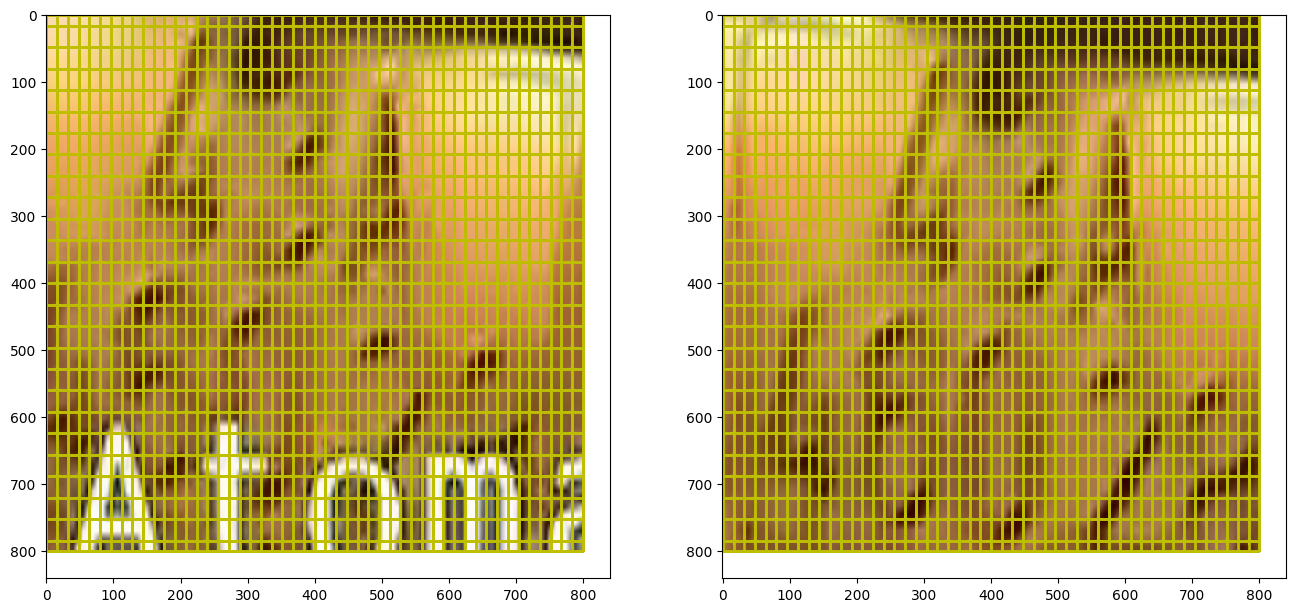

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj.cpu(), anc_pts_y_proj.cpu(), fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj.cpu(), anc_pts_y_proj.cpu(), fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes.cpu(), fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes.cpu(), fig, axes[1], line_width=1)

### Get Positive and Negative Anchors

In [ ]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
#gt_bboxes_all tra ra toan bo box cua cac image
# tra ra box sau khi chia cho width vaf height_scale

#cmt
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')


In [ ]:
gt_bboxes_proj = gt_bboxes_proj.cuda()

In [ ]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)
# print('anc_all',anc_boxes_all.device)
# print('gt_bboxes_all', gt_bboxes_all.device)
# print('anc_boxes_all',anc_boxes_all.device)

anc_flat cuda:0
gt_all cuda:0
ious_mat cuda:0
cuda:0
GT_class torch.cuda.FloatTensor


In [ ]:
GT_class_pos.device

device(type='cuda', index=0)

#### Visualize positive anchor coordinates

In [ ]:
# # project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

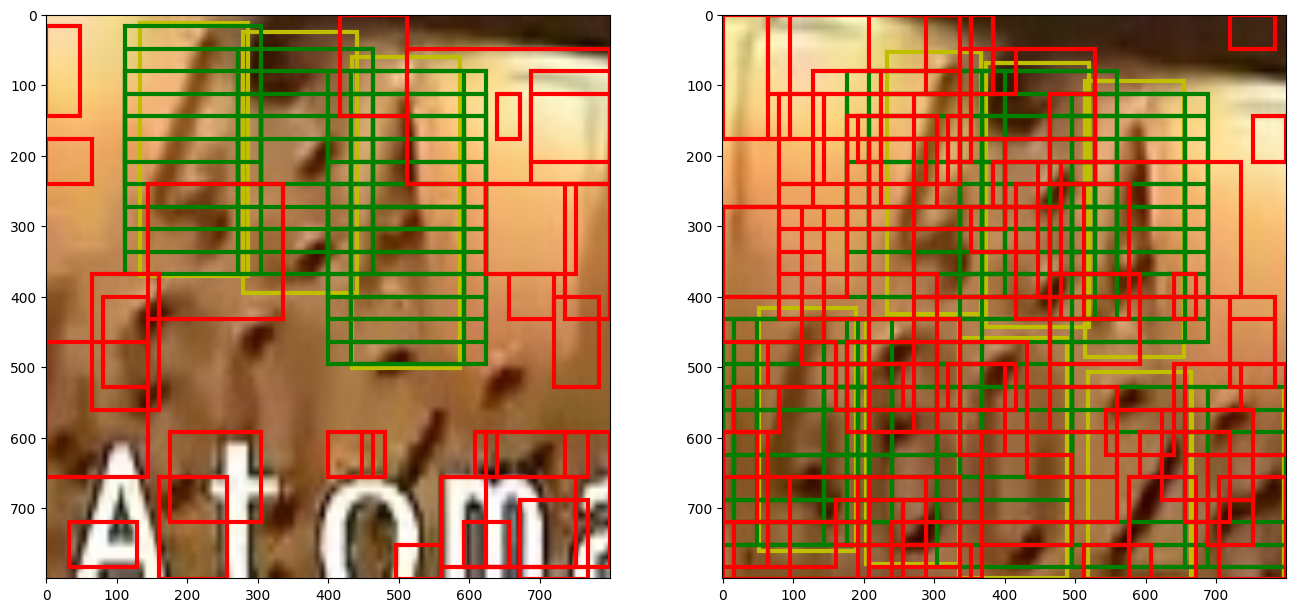

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0].cpu(), fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1].cpu(), fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1.cpu(), fig, axes[0], color='g')
fig, _ = display_bbox(pos_anc_2.cpu(), fig, axes[1], color='g')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1.cpu(), fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2.cpu(), fig, axes[1], color='r')

####Building the model

####confidence head: classify each anchor box as object or background
regeression head: represent predicted offsets of the anchor boxes




In [ ]:
import torch
import torchvision
from torchvision import ops
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

# from utils import *
# from boxes import *

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(pretrained=True)
        device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
        model.to(device)
        req_layers = list(model.children())[:8]
        self.backbone = nn.Sequential(*req_layers)
        for param in self.backbone.named_parameters():
            param[1].requires_grad = True

    def forward(self, img_data):
        # img_data = img_data.to('cuda')
        return self.backbone(img_data)

class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super().__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
        self.n_anchors = n_anchors
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1, device = device)
        self.dropout = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim, n_anchors, kernel_size=1, device = device)
        self.reg_head = nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1, device = device)

    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        # determine mode
        # print('feture', feature_map.device)
        if pos_anc_ind is None or neg_anc_ind is None or pos_anc_coords is None:
            mode = 'eval'
        else:
            mode = 'train'
        device = feature_map.device
        # conv1 = conv1.to(device)
        out = self.conv1(feature_map)
        out = F.relu(self.dropout(out))
        # print('out',out.device)
        reg_offsets_pred = self.reg_head(out) # (B, A*4, hmap, wmap)
        # print(reg_offsets_pred)
        conf_scores_pred = self.conf_head(out) # (B, A, hmap, wmap)
        # print(conf_scores_pred.size())
        # print(pos_anc_ind)
        if mode == 'train':
            # get conf scores
            conf_scores_pos = conf_scores_pred.flatten()[pos_anc_ind]
            # print(conf_scores_pos)
            conf_scores_neg = conf_scores_pred.flatten()[neg_anc_ind]
            # get offsets for +ve anchors
            offsets_pos = reg_offsets_pred.contiguous().view(-1, 4)[pos_anc_ind]
            # print(offsets_pos)
            # generate proposals using offsets
            proposals = generate_proposals(pos_anc_coords, offsets_pos)

            return conf_scores_pos, conf_scores_neg, offsets_pos, proposals

        elif mode == 'eval':
            return conf_scores_pred, reg_offsets_pred

class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super().__init__()

        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size

        # downsampling scale factor
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h

        # scales and ratios for anchor boxes
        self.anc_scales = [2, 4, 6]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)

        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3

        # weights for loss
        self.w_conf = 1
        self.w_reg = 5

        self.feature_extractor = FeatureExtractor()
        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)

    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(dim=0)
        feature_map = self.feature_extractor(images)
        device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        # print('anc_pts_x', anc_pts_x.device)
        # print('anc_pts_y',anc_pts_y.device)
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        # print('anc_base',type(anc_base.device))
        # anc_base = anc_base.device
        # print(type(anc_boxes_all))
        # anc_boxes_all = anc_boxes_all.device
        # print('anc_boxes_all', anc_boxes_all.devide)
        # get positive and negative anchors amongst other things
        gt_bboxes_proj = project_bboxes(gt_bboxes, self.width_scale_factor, self.height_scale_factor, mode='p2a')

        # anc_boxes_all = anc_boxes_all.to('cuda')
        # gt_bboxes_proj = gt_bboxes_proj.to('cuda')
        # gt_classes = gt_classes.to('cuda')

        # print('1',gt_classes.device)
        print('len_anc', len(anc_boxes_all))
        print('len_gt_bbox', len(gt_bboxes_proj))
        positive_anc_ind, negative_anc_ind, GT_conf_scores, \
        GT_offsets, GT_class_pos, positive_anc_coords, \
        negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes)
        print('GT_off', len(GT_offsets))
        print(type(GT_offsets))
        if len(GT_offsets)==0:
          # continue
          total_rpn_loss = torch.tensor(0, device = device)
          proposals = torch.cuda.LongTensor([[-1,-1,-1,-1]])
        else:
          # pass through the proposal module
          conf_scores_pos, conf_scores_neg, offsets_pos, proposals = self.proposal_module(feature_map, positive_anc_ind, \
                                                                                          negative_anc_ind, positive_anc_coords)
          print('len_off_pos', len(offsets_pos))
          # print('proposals',(proposals))
          # print(conf_scores_pos)
          # print(conf_scores_neg)
          cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
          reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)

          total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss
          # print(total_rpn_loss)
          print('cls_loss',cls_loss)
          print('reg_loss',reg_loss)
        # print(total_rpn_loss)
        return total_rpn_loss, feature_map, proposals, positive_anc_ind_sep, GT_class_pos

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        with torch.no_grad():
            batch_size = images.size(dim=0)
            device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
            images = images.to(device)
            feature_map = self.feature_extractor(images)
            feature_map = feature_map.to(device)
            # print(feature_map.device)
            # generate anchors
            anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
            anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
            anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
            anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

            # get conf scores and offsets
            conf_scores_pred, offsets_pred = self.proposal_module(feature_map)
            conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
            offsets_pred = offsets_pred.reshape(batch_size, -1, 4)

            # filter out proposals based on conf threshold and nms threshold for each image
            proposals_final = []
            conf_scores_final = []
            for i in range(batch_size):
                conf_scores = torch.sigmoid(conf_scores_pred[i])
                offsets = offsets_pred[i]
                anc_boxes = anc_boxes_flat[i]
                proposals = generate_proposals(anc_boxes, offsets)
                # filter based on confidence threshold
                conf_idx = torch.where(conf_scores >= conf_thresh)[0]
                conf_scores_pos = conf_scores[conf_idx]
                proposals_pos = proposals[conf_idx]
                # filter based on nms threshold
                nms_idx = ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
                conf_scores_pos = conf_scores_pos[nms_idx]
                proposals_pos = proposals_pos[nms_idx]

                proposals_final.append(proposals_pos)
                conf_scores_final.append(conf_scores_pos)

        return proposals_final, conf_scores_final, feature_map

class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

        self.roi_size = roi_size
        # hidden network
        self.avg_pool = nn.AvgPool2d(self.roi_size)
        self.fc = nn.Linear(out_channels, hidden_dim, device = device)
        self.dropout = nn.Dropout(p_dropout)

        # define classification head
        self.cls_head = nn.Linear(hidden_dim, n_classes, device=device)

    def forward(self, feature_map, proposals_list, gt_classes=None):

        # len(proposals_list)= batch_size
        # inference thi tat di; train thi bat len
      if (len([gt_classes]) == 0):
        cls_loss = torch.tensor(0)
      else:
        if gt_classes is None:
            mode = 'eval'
        else:
            mode = 'train'



        # apply roi pooling on proposals followed by avg pooling
        # print('type_map', type(feature_map))
        # print('type_proposals', type(proposals_list))
        feature_map = feature_map.float()
        print('feature_map_type',feature_map.type())
        roi_out = ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)

        # flatten the output
        roi_out = roi_out.squeeze(-1).squeeze(-1)
        # print(roi_out.size())

        # pass the output through the hidden network
        out = self.fc(roi_out)
        # print(out.size())
        out = F.relu(self.dropout(out))
        # print(out.size())
        # get the classification scores

        cls_scores = self.cls_head(out)
        # print(cls_scores)
        if mode == 'eval':
            return cls_scores
        # compute cross entropy loss

        cls_loss = F.cross_entropy(cls_scores, gt_classes.long())
        # print(cls_loss)
      return cls_loss

class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
        super().__init__()
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)

    def forward(self, images, gt_bboxes, gt_classes):
        # device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

        # images = images.to(device)
        # gt_bboxes = gt_bboxes.to(device)
        # gt_classes = gt_classes.to(device)
        total_rpn_loss, feature_map, proposals, \
        positive_anc_ind_sep, GT_class_pos = self.rpn(images, gt_bboxes, gt_classes)

        # total_rpn_loss = total_rpn_loss.to(device)
        # feature_map = feature_map.to(device)
        # proposals = proposals.to(device)
        # positive_anc_ind_sep  = posotive_anc_ind_sep.to(device)
        # GT_class_pos = GT_class_pos.to(device)

        # get separate proposals for each sample
        pos_proposals_list = []
        batch_size = images.size(dim=0)
        for idx in range(batch_size):
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)
        # print('pos_list',type(pos_proposals_list))
        cls_loss = self.classifier(feature_map, pos_proposals_list, GT_class_pos)
        print('cls_loss_ml',cls_loss)#size
        print('total_rpn_loss',total_rpn_loss)
        total_loss = cls_loss + total_rpn_loss

        return total_loss

    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        batch_size = images.size(dim=0)
        proposals_final, conf_scores_final, feature_map = self.rpn.inference(images, conf_thresh, nms_thresh)
        cls_scores = self.classifier(feature_map, proposals_final)

        # convert scores into probability
        cls_probs = F.softmax(cls_scores, dim=-1)
        # get classes with highest probability
        classes_all = torch.argmax(cls_probs, dim=-1)

        classes_final = []
        # slice classes to map to their corresponding image
        c = 0
        for i in range(batch_size):
            n_proposals = len(proposals_final[i]) # get the number of proposals for each image
            classes_final.append(classes_all[c: c+n_proposals])
            c += n_proposals

        return proposals_final, conf_scores_final, classes_final

# ------------------- Loss Utils ----------------------

def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
    target_pos = torch.ones_like(conf_scores_pos)
    target_neg = torch.zeros_like(conf_scores_neg)

    target = torch.cat((target_pos, target_neg))
    inputs = torch.cat((conf_scores_pos, conf_scores_neg))

    loss = F.binary_cross_entropy_with_logits(inputs, target, reduction='mean') * 1. / batch_size

    return loss

def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
    assert gt_offsets.size() == reg_offsets_pos.size()
    loss = F.smooth_l1_loss(reg_offsets_pos, gt_offsets, reduction='mean') * 1. / batch_size
    return loss

In [ ]:
# out_h, out_w = out_size
# device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

# out_size = out_size.device
# out_size.device

In [ ]:
# type(out_size)

In [ ]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

out_size = torch.as_tensor(out_size, device = device)
detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [ ]:
# detector

In [ ]:
# detector.eval()
# total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)# in classification
# proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

In [ ]:
# detector.train()

In [ ]:
# total_loss.size()

Check point


In [ ]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    # if is_best:
    #     shutil.copyfile(filename, 'model_best.pth.tar')

In [ ]:
%cd /content/drive/MyDrive/CV

/content/drive/.shortcut-targets-by-id/1Z7Jw0F18-t6b1J_nNXzSsOUMRtwvcH17/CV


In [ ]:
# load checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

checkpoint = torch.load('checkpoint.pth.tar',map_location=torch.device(device))
detector.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
n_epochs = checkpoint['epoch']
total_loss = checkpoint['loss']

In [ ]:
# checkpoint['loss']

In [ ]:
# t1.device

### Training loop

In [ ]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #load checkpoint
    optimizer.load_state_dict(checkpoint['optimizer'])
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    print(device)
    model.train()
    model.to(device)
    # print(next(model.parameters()).is_cuda)
    loss_list = []

    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            gt_classes_batch = gt_classes_batch.to(device)
            # print('gt',gt_classes_batch.device)
            # print(type(img_batch))
            # forward pass
            # model.to('cuda')
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            print('loss',loss)
            # backpropagation
            optimizer.zero_grad()
            if loss == 0:
              continue
            else:
              loss.backward()
              optimizer.step()

            total_loss += loss.item()
            print('total_loss',total_loss)
            # print('loss: ', loss.item())
        save_checkpoint({
    'epoch': n_epochs + 1,
    # 'arch': args.arch,
    'state_dict': model.state_dict(),
    # 'best_acc1': best_acc1,
    'optimizer' : optimizer.state_dict(),
    'loss' : total_loss
    # 'scheduler' : scheduler.state_dict()
})
        loss_list.append(total_loss)
        # print(f"Epoch {n_epochs:2d}")
        # print('loss: ', loss_list)
    return loss_list

In [ ]:
%cd /content/drive/MyDrive/CV

/content/drive/.shortcut-targets-by-id/1Z7Jw0F18-t6b1J_nNXzSsOUMRtwvcH17/CV


In [ ]:
# epoch

In [ ]:
# optimizer = optim.Adam(detector.parameters(), lr=1e-3)
# optimizer.step()

In [ ]:
learning_rate = 1e-3
n_epochs = 100

# from utils import *
loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

cuda


  0%|          | 0/100 [00:00<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
a = torch.tensor(13)
if a == 13:
  print('mm')

In [ ]:
# loss_list

In [ ]:
# plt.plot(loss_list)

#### save model

In [ ]:
# torch.save(detector.state_dict(), "model_200.pt")

In [ ]:
# #load model
# load_detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)
# load_detector.load_state_dict(torch.load('model_200.pt'))
# # load_detector.eval()

In [ ]:
# next(load_detector.parameters())

In [ ]:
# #load and retrain model
# load_detector.eval()
# learning_rate = 1e-3
# n_epochs = 10

# loss_list = training_loop(load_detector, learning_rate, od_dataloader, n_epochs)

In [ ]:
# for param in load_detector.parameters():
#   print(param)

### Inference

In [ ]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.9, nms_thresh=0.02)

feature_map_type torch.cuda.FloatTensor


In [ ]:
proposals_final

[tensor([[15.2220, 18.6487, 18.5153, 20.8984],
         [14.6959, 16.2846, 17.2458, 17.9733],
         [13.8534,  6.6861, 20.2872, 11.0157],
         [ 6.9163,  2.7341, 10.2147,  9.2079],
         [10.6247, 16.5790, 14.6418, 20.6955],
         [11.1286,  1.7478, 14.3602,  8.2458],
         [10.6230, 10.5280, 12.6876, 12.6052]], device='cuda:0'),
 tensor([[15.6083, 17.1775, 17.7593, 19.3684],
         [15.2247, 20.7371, 18.4520, 22.8142],
         [ 5.8869,  3.0511, 11.8972,  9.6876],
         [ 9.7272, 19.4644, 15.4825, 23.5403],
         [10.6180, 10.4542, 12.6613, 12.6921],
         [15.1986,  5.7117, 18.5380, 11.9846],
         [ 9.9897, 13.5046, 13.1851, 15.6158],
         [11.0032, 16.5141, 12.0489, 18.6177]], device='cuda:0')]

In [ ]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

In [ ]:
prop_proj_2 = prop_proj_2.cpu()
prop_proj_1 = prop_proj_1.cpu()

In [ ]:
classes_final

[tensor([ 7,  5, 10,  4,  5,  3,  8], device='cuda:0'),
 tensor([4, 0, 7, 0, 1, 7, 9, 4], device='cuda:0')]

In [ ]:
conf_scores_final

[tensor([1.0000, 0.9741, 0.9355, 0.9080, 0.8742, 0.8675, 0.8572],
        device='cuda:0'),
 tensor([1.0000, 0.9580, 0.9188, 0.8929, 0.8868, 0.8830, 0.8685, 0.8595],
        device='cuda:0')]

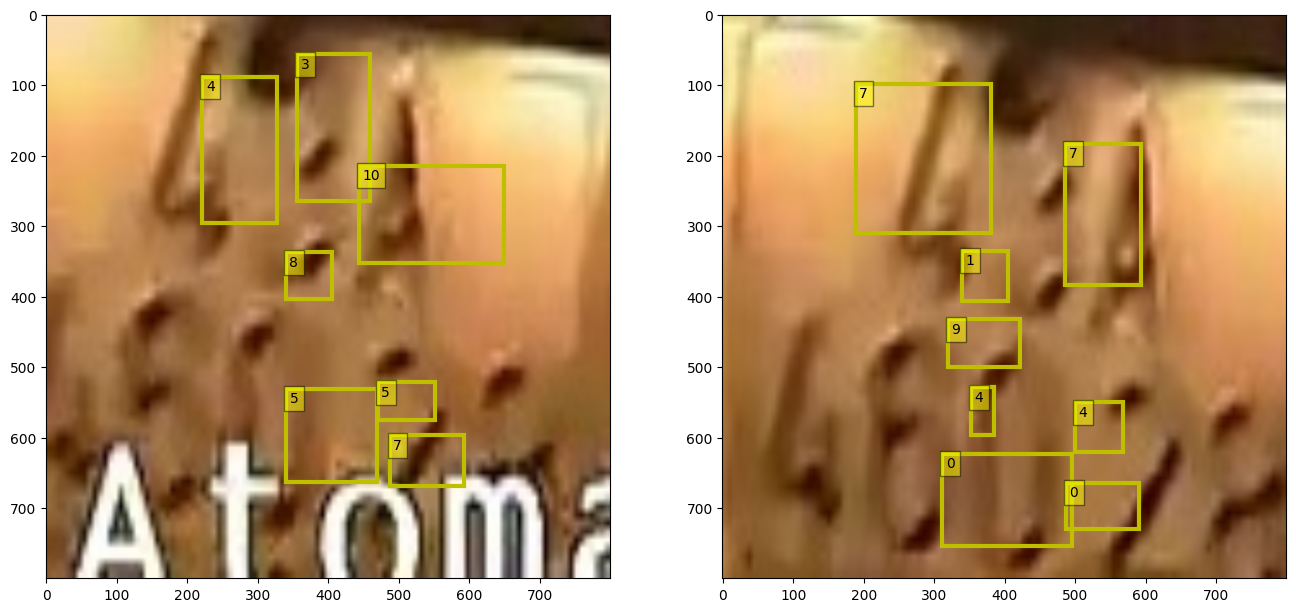

In [ ]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1.cpu(), fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2.cpu(), fig, axes[1], classes=classes_pred_2)